# Introduction

This notebook will go through the basic steps of preparing the input and calculating non-local quantities.

# Input

The first step will be the preparation of input data. For this tutorial we assume, that you have been provided with a file containing the DMFT output data. 

We will convert this file to an input file for the `LadderDGA.jl` code and generate a frequency mesh. 

You can also peak into HDF5 files using the Julia HDF5 package.

In [1]:
using HDF5
path_to_input = "/home/julian/Hamburg/lDGA_checks/square_test/U2_n1_b12.h5"
f = h5open(path_to_input)

🗂️ HDF5.File: (read-only) /home/julian/Hamburg/lDGA_checks/square_test/U2_n1_b12.h5
├─ 📂 G_imp
│  ├─ 🏷️ Format
│  ├─ 🔢 data
│  │  └─ 🏷️ __complex__
│  └─ 📂 mesh
│     ├─ 🏷️ Format
│     ├─ 📂 domain
│     │  ├─ 🔢 beta
│     │  └─ 🔢 statistic
│     ├─ 🔢 positive_freq_only
│     └─ 🔢 size
├─ 📂 Sigma_imp
│  ├─ 🏷️ Format
│  ├─ 🔢 data
│  │  └─ 🏷️ __complex__
│  └─ 📂 mesh
│     ├─ 🏷️ Format
│     ├─ 📂 domain
│     │  ├─ 🔢 beta
│     │  └─ 🔢 statistic
│     ├─ 🔢 positive_freq_only
│     └─ 🔢 size
├─ 📂 chi_updn_ph_imp
│  ├─ 🏷️ Format
│  ├─ 🔢 data
│  │  └─ 🏷️ __complex__
│  └─ 📂 mesh
│     ├─ 🏷️ Format
│     ├─ 📂 MeshComponent0
│     │  ├─ 🏷️ Format
│     │  ├─ 📂 domain
│     │  │  ├─ 🔢 beta
│     │  │  └─ 🔢 statistic
│     │  ├─ 🔢 positive_freq_only
│     │  └─ 🔢 size
│     ├─ 📂 MeshComponent1
│     │  ├─ 🏷️ Format
│     │  ├─ 📂 domain
│     │  │  ├─ 🔢 beta
│     │  │  └─ 🔢 statistic
│     │  ├─ 🔢 positive_freq_only
│     │  └─ 🔢 size
│     └─ 📂 MeshComponent2
│        ├─ 🏷️ Format
│        ├─ 

## TRIQS Conversion

If you are starting out with DMFT data from TRIQS, the `triqs_conv.jl` script in the scripts subdirectory of the `LadderDGA.jl` code will responsible for the conversion. This script also utilizes the `SparseVertex` and `EquivalencyClassesConstructor.jl` packages. 

Most of the conversion scripts are built to be called from the command line with the input given as parameters.
In Julia call parameters are stored in the `ARGS` array. Thus, in order to emulate a call with parameters in jupyter notebooks, we will modify this array befor calls to scripts.

We start by adding the path to a triqs output file and a directory for the script output (`@__DIR__` points to the directory the current script runs in) to the `ARGS` array and executing the `triqs_conv.jl` script for this input.
The input file is NOT provided with this example!

If you want to know more about a function, you can type `? function_name` in any cell to view the docstring.

In [2]:
path_to_input = "/home/julian/Hamburg/lDGA_checks/square_test/U2_n1_b12.h5"
path_to_output = "/home/julian/Hamburg/lDGA_checks/square_test"
empty!(ARGS)
push!(ARGS,path_to_input)
push!(ARGS,path_to_output)
include("../scripts/triqs_conv.jl")

Generating freqency mesh with bosonic -59:59, fermionic -60:59 indices
Constructing Array
Starting Computation 3
  1.423200 seconds (139.49 k allocations: 110.947 MiB, 22.98% compilation time)
  0.209592 seconds (60 allocations: 16.170 MiB, 42.76% gc time)
  0.488701 seconds (11 allocations: 78.148 MiB)


## Config File
You will find two new files in the `path_to_output` directory. Before we can start the calculation we need to specify a configuration file which will point `LadderDGA.jl` to these files and provide all necessary parameters.

You will find an example configuration named `config.toml` in the root directory of `LadderDGA.jl`.
`U`, `mu`, `beta`, `nden` and `kGrid` should be set according to your DMFT calculation. The syntax for the `kGrid` parameter is as follows: The grid is given as a string starting with the grid name (see also `Dispersions.jl` for more information), followed by additional parameters, separated by `-`. Currently `2Dsc` and `3Dsc` are available with a single parameter for the hopping to neighbouring sites. Examples are `"2Dsc-0.25"` or `"3Dsc-0.408248"`

Remember to set the `inputDir` and `freqFile` variables to the previously generated files.

# Running the code

The `LadderDGA.jl` code consists of a collection of functions but no linear program flow. This means one has to define a script which defines the actual program flow.
Some examples can be found in the root directory of the project. Here we will go through a typical program flow, also giving us the opportunity to plot quantities at differnts steps of the calculation.
First, point the `cfg_file` variable to your edited configuration file.
We then also tell Julia to use `Plots` and `LadderDGA`.

In [28]:
cfg_file = "/home/julian/Hamburg/lDGA_checks/square_test/config.toml"
cfg_file2 = "/home/julian/Hamburg/lDGA_checks/square_test/config_r.toml"
cfg_fileED = "/home/julian/Hamburg/lDGA_checks/square_test/ED/config.toml"
cfg_fileED2 = "/home/julian/Hamburg/lDGA_checks/square_test/ED/config_r.toml"

using Plots
using LadderDGA

The next step will read the config and input files and set up all variables for you.
The `kGrids` and `qGrids` (reduced k grid) arrays contain k grids of the sizes specified in the `Nk` array in your `config.toml`. 
This can be handy for finite size scaling, but for now we will stick with simple calculations and only use a single k grid size.
Finally we will also need to read in the DMFT quantities. `setup_LDGA` will do just that.

Note: the full grids (here stored in the kGrids array) are deprecated. They will be removed from future versions, together with most debug variables (all variables in the return list of `readConfig` after `qGridLoc`).

In [29]:
mP, sP, env, kGrids, qGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file)
kG = kGrids[1]
qG = qGrids[1]
νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp_fft, GLoc_fft, Σ_loc, FUpDo, gImp, gLoc = setup_LDGA(kG, freqList, mP, sP, env);

┌ Info: Reading Inputs...
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/IO.jl:7
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:88
┌ Info: setting usable ranges of sp and ch channel from 39:81 and 39:81 to the same range of 39:81
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:140
┌ Warning: Could not find hubb.andpar and gm_wim for kinetic energy. proceding without improved bosonic sums!
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:153
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_sp(39:81) = 0.2072, χLoc_ch(39:81) = 0.1294 
│ sum χupup check (fit, tail sub, tail sub + fit, expected): 0.16830880832033185 ?≈? 0.1692651628105114 ?=? 0.16830880832033182 ?≈? 0.25"
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:174


In [30]:
mP2, sP2, env2, kGrids, qGrids, qGridLoc, freqRed_map2, freqList2, freqList_min2, parents2, ops2, nFermi2, nBose2, shift2, base2, offset2 = readConfig(cfg_file2)
νGrid2, sumHelper_f2, impQ_sp2, impQ_ch2, GImp_fft2, GLoc_fft2, Σ_loc2, FUpDo2, gImp2, gLoc2 = setup_LDGA(kG, freqList2, mP2, sP2, env2);

┌ Info: Reading Inputs...
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/IO.jl:7
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:88
┌ Info: setting usable ranges of sp and ch channel from 32:88 and 29:91 to the same range of 32:88
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:140
┌ Warning: Could not find hubb.andpar and gm_wim for kinetic energy. proceding without improved bosonic sums!
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:153
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_sp(32:88) = 0.2458, χLoc_ch(32:88) = 0.1881 
│ sum χupup check (fit, tail sub, tail sub + fit, expected): 0.21692485237026116 ?≈? 0.2168414561196791 ?=? 0.21692485237026085 ?≈? 0.25"
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:174


In [33]:
mPED, sPED, envED, kGridsED, qGridsED, qGridLocED, freqRed_mapED, freqListED, freqList_minED, parentsED, opsED, nFermiED, nBoseED, shiftED, baseED, offsetED = readConfig(cfg_fileED)
νGridED, sumHelper_fED, impQ_spED, impQ_chED, GImp_fftED, GLoc_fftED, Σ_locED, FUpDoED, gImpED, gLocED = setup_LDGA(kG, freqListED, mPED, sPED, envED);

mPED2, sPED2, envED2, kGridsED2, qGridsED2, qGridLocED2, freqRed_mapED2, freqListED2, freqList_minED2, parentsED2, opsED2, nFermiED2, nBoseED2, shiftED2, baseED2, offsetED2 = readConfig(cfg_fileED2)
νGridED2, sumHelper_fED2, impQ_spED2, impQ_chED2, GImp_fftED2, GLoc_fftED2, Σ_locED2, FUpDoED2, gImpED2, gLocED2 = setup_LDGA(kG, freqListED2, mPED2, sPED2, envED2);

┌ Info: Reading Inputs...
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/IO.jl:7
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:88
┌ Info: setting usable ranges of sp and ch channel from 32:70 and 32:70 to the same range of 32:70
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:140
┌ Info: Computing kinetic energie for improved bosonic sums.
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:148
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_sp(32:70) = 0.1933, χLoc_ch(32:70) = 0.1282 
│ sum χupup check (fit, tail sub, tail sub + fit, expected): 0.1607689525921039 ?≈? 0.2098551034245942 ?=? 0.18638277751286125 ?≈? 0.25"
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:174
┌ Info: Reading Inputs...
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/IO.jl:7
┌ Warning: TODO: check beta consistency, confi

In [32]:
function filter_MA(m::Int, X::AbstractArray{T,1}) where T <: Number
    res = deepcopy(X) 
    offset = trunc(Int,m/2)
    res[1+offset] = sum(@view X[1:m])/m
    for (ii,i) in enumerate((2+offset):(length(X)-offset))
        res[i] = res[i-1] + (X[m+ii] - X[ii])/m
    end
    return res
end

function filter_MA!(res::AbstractArray{T,1}, m::Int, X::AbstractArray{T,1}) where T <: Number 
    offset = trunc(Int,m/2)
    res[1+offset] = sum(@view X[1:m])/m
    for (ii,i) in enumerate((2+offset):(length(X)-offset))
        res[i] = res[i-1] + (X[m+ii] - X[ii])/m
    end
    return res
end

function filter_KZ(m::Int, k::Int, X::AbstractArray{T,1}) where T <: Number
    res = filter_MA(m, X)
    for ki in 2:k
        res = filter_MA!(res, m, res)
    end
    return res
end

filter_KZ (generic function with 1 method)

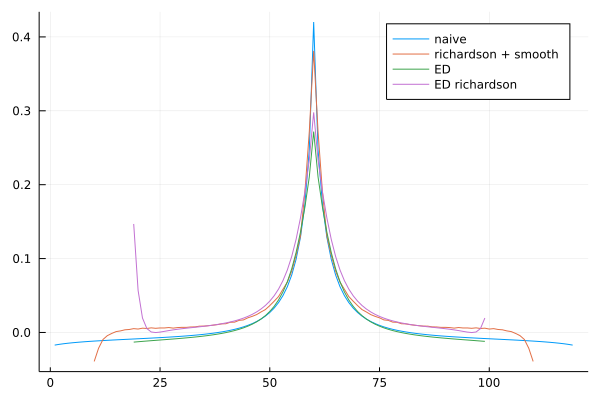

In [46]:
t1 = sum_freq(impQ_sp.χ, [2,3], LadderDGA.Naive(), mP.β)[:,1,1]
sh_f = LadderDGA.get_sum_helper(2*sP.n_iν, sP2, :f)
t2 = sum_freq(impQ_sp2.χ, [2,3], sh_f, mP.β)[:,1,1]

sh_fED = LadderDGA.get_sum_helper(2*sP.n_iν, sPED, :f)
t1ED = sum_freq(impQ_spED.χ, [2,3], sh_fED, mP.β)[:,1,1]
sh_fED2 = LadderDGA.get_sum_helper(2*sP.n_iν, sPED2, :f)
t2ED = sum_freq(impQ_spED2.χ, [2,3], sh_fED2, mP.β)[:,1,1]

t3 = deepcopy(t2)
nh   = ceil(Int64, size(t3,1)/2)
t3[nh:end] = filter_KZ(3,1,t3[nh:end])
t3[1:nh] = filter_MA(3,t3[1:nh])

plot(1:119, real.(t1), label="naive")
range = 10:110
rangeED = 10:90
#plot!(range, real.(t2[range]), label="richardson")
plot!(range, real.(t3[range]), label="richardson + smooth")
plot!(rangeED .+ 9, real.(t1ED[rangeED]), label="ED")
plot!(rangeED .+ 9, real.(t2ED[rangeED]), label="ED richardson")

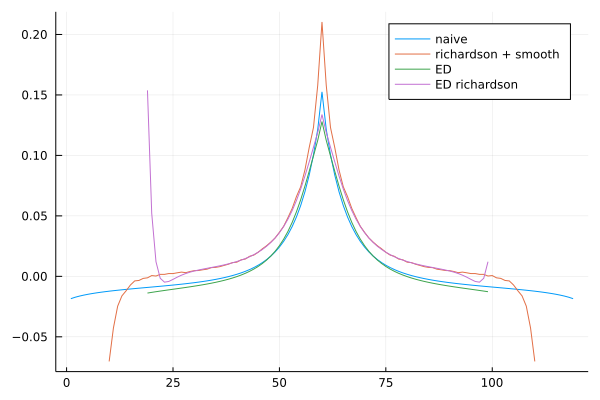

In [45]:
t1 = sum_freq(impQ_ch.χ, [2,3], LadderDGA.Naive(), mP.β)[:,1,1]
sh_f = LadderDGA.get_sum_helper(2*sP.n_iν, sP2, :f)
t2 = sum_freq(impQ_ch2.χ, [2,3], sh_f, mP.β)[:,1,1]

sh_fED = LadderDGA.get_sum_helper(2*sP.n_iν, sPED, :f)
t1ED = sum_freq(impQ_chED.χ, [2,3], sh_fED, mP.β)[:,1,1]
sh_fED2 = LadderDGA.get_sum_helper(2*sP.n_iν, sPED2, :f)
t2ED = sum_freq(impQ_chED2.χ, [2,3], sh_fED2, mP.β)[:,1,1]

t3 = deepcopy(t2)
nh   = ceil(Int64, size(t3,1)/2)
t3[nh:end] = filter_KZ(3,1,t3[nh:end])
t3[1:nh] = filter_KZ(3,1,t3[1:nh])

plot(1:119, real.(t1), label="naive")
range = 10:110
rangeED = 10:90
#plot!(range, real.(t2[range]), label="richardson")
plot!(range, real.(t3[range]), label="richardson + smooth")
plot!(rangeED .+ 9, real.(t1ED[rangeED]), label="ED")
plot!(rangeED .+ 9, real.(t2ED[rangeED]), label="ED richardson")

We are now in the position to calculate the ladder DGA self energy. The first 5 lines compute all quantities on a lattice of size 1. The resulting self energy is used to cancel out discretization errors and finite size effects in the full self energy.

In [9]:
bubbleLoc = calc_bubble(νGrid, GImp_fft, qGridLoc, mP, sP)
locQ_sp = calc_χ_trilex(impQ_sp.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, mP.U, mP, sP);
locQ_ch = calc_χ_trilex(impQ_ch.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, -mP.U, mP, sP);
Σ_ladderLoc = calc_Σ(locQ_sp, locQ_ch, bubbleLoc, GImp_fft, FUpDo, qGridLoc, sumHelper_f, mP, sP)
Σ_ladderLoc = Σ_ladderLoc .+ mP.n * mP.U/2.0;


bubble = calc_bubble(νGrid, GLoc_fft, qG, mP, sP);
nlQ_sp = calc_χ_trilex(impQ_sp.Γ, bubble, qG, νGrid, sumHelper_f, mP.U, mP, sP);
nlQ_ch = calc_χ_trilex(impQ_ch.Γ, bubble, qG, νGrid, sumHelper_f, -mP.U, mP, sP);
nlQ_sp_nλ = deepcopy(nlQ_sp)
nlQ_ch_nλ = deepcopy(nlQ_ch)
λ_sp, λ_spch  = λ_correction!(impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp, nlQ_ch, bubble, GLoc_fft, qG, mP, sP)

Σ_ladder = calc_Σ(nlQ_sp, nlQ_ch, bubble, GLoc_fft, FUpDo, qG, sumHelper_f, mP, sP)
Σ_ladder_corrected = Σ_ladder .- Σ_ladderLoc .+ Σ_loc[1:size(Σ_ladder,1)];

LoadError: UndefVarError: ωi not defined

# Visualization

The main advantage of calculations in jupyter notebooks are the convenient options for data visualization. The following cells give examples for plotting in Julia

In [10]:
sh = LadderDGA.get_sum_helper(nlQ_ch.usable_ω, sP, :b)
χch_ω = LadderDGA.kintegrate(qG, nlQ_ch.χ, dim=2)[:,1]
χch_sum = real(LadderDGA.sum_freq(χch_ω[nlQ_ch.usable_ω], [1], sh, mP.β)[1])
real(impQ_ch.χ_loc + impQ_sp.χ_loc - χch_sum)

sh = LadderDGA.get_sum_helper(nlQ_sp.usable_ω, sP, :b)
χsp_ω = LadderDGA.kintegrate(qG, nlQ_sp.χ, dim=2)[:,1]
χsp_sum = real(LadderDGA.sum_freq(χsp_ω[nlQ_sp.usable_ω], [1], sh, mP.β)[1])

LoadError: UndefVarError: nlQ_ch not defined

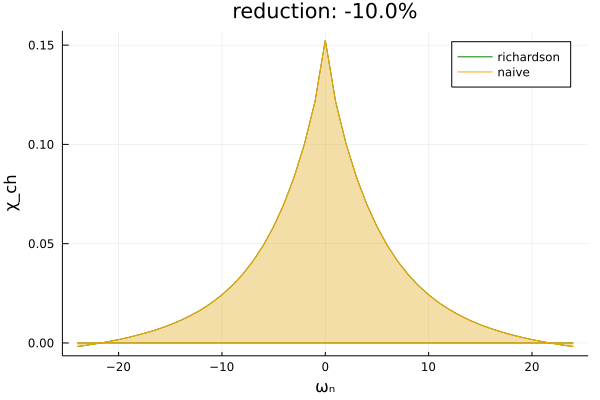

In [11]:
χchED_ω_naive = sum(impQ_ch.χ,dims=[2,3])[:,1,1]/(mP.β^2);
χspED_ω_naive = sum(impQ_sp.χ,dims=[2,3])[:,1,1]/(mP.β^2);

reduction_prct = -0.1
χchED_ω_fit = [LadderDGA.sum_freq(impQ_ch.χ[i,:,:], [1,2], sumHelper_f, mP.β)[1,1] for i in 1:size(impQ_ch.χ,1)];
χspED_ω_fit = [LadderDGA.sum_freq(impQ_sp.χ[i,:,:], [1,2], sumHelper_f, mP.β)[1,1] for i in 1:size(impQ_sp.χ,1)];
usable_ch = LadderDGA.find_usable_interval(real(χchED_ω_fit), reduce_range_prct=reduction_prct)
usable_sp = LadderDGA.find_usable_interval(real(χspED_ω_fit), reduce_range_prct=reduction_prct)
usable_fit_DMFT = intersect(usable_ch, usable_sp)

usable_naive_ch = LadderDGA.find_usable_interval(real(χchED_ω_naive), reduce_range_prct=reduction_prct)
usable_naive_sp = LadderDGA.find_usable_interval(real(χspED_ω_naive), reduce_range_prct=reduction_prct)


plot(usable_ch .- sP.n_iω .- 1, real(χchED_ω_fit[usable_ch]), label="richardson", c=:green)
plot!(usable_ch .- sP.n_iω .- 1, repeat([0], length(usable_ch)), fillrange=real(χchED_ω_fit[usable_ch]), fillalpha=0.06, c=:green, label=nothing)

plot!(usable_naive_ch .- sP.n_iω .- 1, real(χchED_ω_naive[usable_naive_ch]), label="naive", xlabel="ωₙ", ylabel="χ_ch", c=:orange, title="reduction: $(reduction_prct*100)%")
plot!(usable_naive_ch .- sP.n_iω .- 1, repeat([0], length(usable_naive_ch)), fillrange=real(χchED_ω_naive[usable_naive_ch]), fillalpha=0.3, c=:orange, label=nothing)


### non-local quantities

In [12]:
bubbleLoc2 = calc_bubble(νGrid2, GImp_fft2, qGridLoc, mP2, sP2)
locQ_sp2 = calc_χ_trilex(impQ_sp2.Γ, bubbleLoc2, qGridLoc, νGrid2, sumHelper_f2, mP2.U, mP2, sP2);
locQ_ch2 = calc_χ_trilex(impQ_ch2.Γ, bubbleLoc2, qGridLoc, νGrid2, sumHelper_f2, -mP2.U, mP2, sP2);
Σ_ladderLoc2 = calc_Σ(locQ_sp2, locQ_ch2, bubbleLoc2, GImp_fft2, FUpDo2, qGridLoc, sumHelper_f2, mP2, sP2)
Σ_ladderLoc2 = Σ_ladderLoc2 .+ mP2.n * mP2.U/2.0;


bubble2 = calc_bubble(νGrid2, GLoc_fft2, qG, mP2, sP2);
nlQ_sp2 = calc_χ_trilex(impQ_sp2.Γ, bubble2, qG, νGrid2, sumHelper_f2, mP2.U, mP2, sP2);
nlQ_ch2 = calc_χ_trilex(impQ_ch2.Γ, bubble2, qG, νGrid2, sumHelper_f2, -mP2.U, mP2, sP2);

nlQ_sp2_nλ = deepcopy(nlQ_sp2)
nlQ_ch2_nλ = deepcopy(nlQ_ch2)
λ_sp2, λ_spch2  = λ_correction!(impQ_sp2, impQ_ch2, FUpDo2, Σ_loc2, Σ_ladderLoc2, nlQ_sp2, nlQ_ch2, bubble2, GLoc_fft2, qG, mP2, sP2)

Σ_ladder2 = calc_Σ(nlQ_sp2, nlQ_ch2, bubble2, GLoc_fft2, FUpDo2, qG, sumHelper_f2, mP2, sP2)
Σ_ladder_corrected2 = Σ_ladder2 .- Σ_ladderLoc2 .+ Σ_loc[1:size(Σ_ladder2,1)];

LoadError: UndefVarError: ωi not defined

In [13]:
# naive:
χch_ω = LadderDGA.kintegrate(qG, nlQ_ch.χ, dim=2)[:,1]
χsp_ω = LadderDGA.kintegrate(qG, nlQ_sp.χ, dim=2)[:,1]
xarr = sort(unique(union(nlQ_ch.usable_ω, nlQ_sp.usable_ω))) 
plot(xarr .- sP.n_iω .- 1, real(χch_ω[xarr]), label="nl χ_ch", legend=:topleft, color=:red)
plot!(twinx(), xarr .- sP.n_iω .- 1, real(χsp_ω[xarr]), label="nl χ_sp")

LoadError: UndefVarError: nlQ_ch not defined

In [14]:
plot(imag.(Σ_ladder_corrected[1:10,1]))
plot!(imag.(Σ_ladder_corrected2[1:10,1]))

LoadError: UndefVarError: Σ_ladder_corrected not defined

In [15]:
plot(real.(Σ_ladder_corrected[:,1]))
plot!(real.(Σ_ladder_corrected2[1:10,1]))

LoadError: UndefVarError: Σ_ladder_corrected not defined

In [16]:
sh2 = LadderDGA.get_sum_helper(nlQ_ch2.usable_ω, sP2, :b)
χch_ω2 = LadderDGA.kintegrate(qG, nlQ_ch2.χ, dim=2)[:,1]
χch_sum2 = real(LadderDGA.sum_freq(χch_ω2[nlQ_ch2.usable_ω], [1], sh2, mP2.β)[1])
real(impQ_ch2.χ_loc + impQ_sp2.χ_loc - χch_sum2)

sh2 = LadderDGA.get_sum_helper(nlQ_sp2.usable_ω, sP2, :b)
χsp_ω2 = LadderDGA.kintegrate(qG, nlQ_sp2.χ, dim=2)[:,1]
χsp_sum2 = real(LadderDGA.sum_freq(χsp_ω2[nlQ_sp2.usable_ω], [1], sh2, mP2.β)[1])

LoadError: UndefVarError: nlQ_ch2 not defined

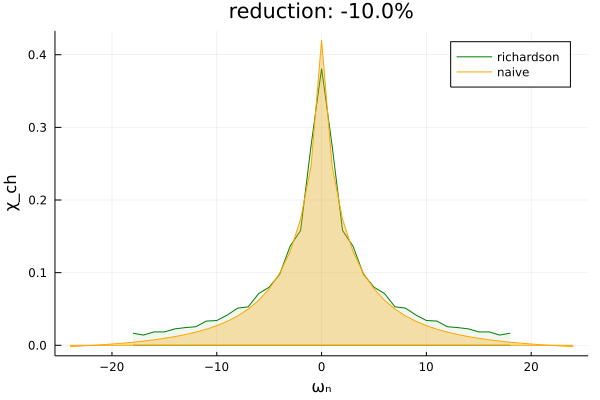

In [17]:
χchED_ω_naive2 = sum(impQ_ch2.χ,dims=[2,3])[:,1,1]/(mP2.β^2);
χspED_ω_naive2 = sum(impQ_sp2.χ,dims=[2,3])[:,1,1]/(mP2.β^2);

reduction_prct = -0.1
χchED_ω_fit2 = [LadderDGA.sum_freq(impQ_ch2.χ[i,:,:], [1,2], sumHelper_f2, mP2.β)[1,1] for i in 1:size(impQ_ch2.χ,1)];
χspED_ω_fit2 = [LadderDGA.sum_freq(impQ_sp2.χ[i,:,:], [1,2], sumHelper_f2, mP2.β)[1,1] for i in 1:size(impQ_sp2.χ,1)];
usable_ch2 = LadderDGA.find_usable_interval(real(χchED_ω_fit2), reduce_range_prct=reduction_prct)
usable_sp2 = LadderDGA.find_usable_interval(real(χspED_ω_fit2), reduce_range_prct=reduction_prct)
usable_fit_DMFT2 = intersect(usable_ch2, usable_sp2)

usable_naive_ch2 = LadderDGA.find_usable_interval(real(χchED_ω_naive2), reduce_range_prct=reduction_prct)
usable_naive_sp2 = LadderDGA.find_usable_interval(real(χspED_ω_naive2), reduce_range_prct=reduction_prct)


plot(usable_sp2 .- sP2.n_iω .- 1, real(χspED_ω_fit2[usable_sp2]), label="richardson", c=:green)
plot!(usable_sp2 .- sP2.n_iω .- 1, repeat([0], length(usable_sp2)), fillrange=real(χspED_ω_fit2[usable_sp2]), fillalpha=0.06, c=:green, label=nothing)

plot!(usable_naive_sp2 .- sP2.n_iω .- 1, real(χspED_ω_naive2[usable_naive_sp2]), label="naive", xlabel="ωₙ", ylabel="χ_ch", c=:orange, title="reduction: $(reduction_prct*100)%")
plot!(usable_naive_sp2 .- sP2.n_iω .- 1, repeat([0], length(usable_naive_sp2)), fillrange=real(χspED_ω_naive2[usable_naive_sp2]), fillalpha=0.3, c=:orange, label=nothing)
